# Deep Gaussian Processes

In [1]:
import torch
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import math

# Generate toy sinusoid dataset
def generate_sinusoid_data(n_points=1000):
    X = torch.linspace(0, 2 * math.pi, n_points, dtype=torch.float64).unsqueeze(1)
    y = torch.sin(X).squeeze() + 0.1 * torch.randn(X.size(0))
    return X, y


X, y = generate_sinusoid_data()

train_n = int(math.floor(0.8 * len(X)))
train_x = X[:train_n, :].contiguous()
train_y = y[:train_n].contiguous()

test_x = X[train_n:, :].contiguous()
test_y = y[train_n:].contiguous()

if torch.cuda.is_available():
    train_x, train_y, test_x, test_y = train_x.cuda(), train_y.cuda(), test_x.cuda(), test_y.cuda()


In [2]:
from torch.utils.data import TensorDataset, DataLoader

train_dataset = TensorDataset(train_x, train_y)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

test_dataset = TensorDataset(test_x, test_y)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [3]:
from gp.deepgp import BotorchDeepGP
import gpytorch
from gpytorch.mlls.variational_elbo import VariationalELBO

# Initialize the model
train_x_shape = train_x.shape
model = BotorchDeepGP(train_x_shape)
likelihood = model.likelihood

if torch.cuda.is_available():
    model = model.cuda()

In [4]:
import tqdm
from gpytorch.mlls import DeepApproximateMLL

# Set training mode
model.train()
likelihood.train()

# Define the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Define the loss function
mll = DeepApproximateMLL(VariationalELBO(likelihood, model, num_data=train_x.size(0)))

num_epochs = 15
num_samples = 10

epochs_iter = tqdm.notebook.tqdm(range(num_epochs), desc="Epoch")
for i in epochs_iter:
    # Within each iteration, we will go over each minibatch of data
    minibatch_iter = tqdm.notebook.tqdm(train_loader, desc="Minibatch", leave=False)
    for x_batch, y_batch in minibatch_iter:
        with gpytorch.settings.num_likelihood_samples(num_samples):
            optimizer.zero_grad()
            output = model(x_batch)
            loss = -mll(output, y_batch)
            loss.backward()
            optimizer.step()

            minibatch_iter.set_postfix(loss=loss.item())

Epoch:   0%|          | 0/15 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/25 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/25 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/25 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/25 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/25 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/25 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/25 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/25 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/25 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/25 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/25 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/25 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/25 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/25 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/25 [00:00<?, ?it/s]

In [5]:
# Evaluate the model
model.eval()

# Predict for the training set
train_loader = DataLoader(train_dataset, batch_size=1024, shuffle=False)
train_predictive_means, train_predictive_variances, _ = model.predict(train_loader)

# Predict for the test set
test_loader = DataLoader(test_dataset, batch_size=1024, shuffle=False)
test_predictive_means, test_predictive_variances, test_lls = model.predict(test_loader)

rmse = torch.mean(torch.pow(test_predictive_means.mean(0) - test_y, 2)).sqrt()
print(f"RMSE: {rmse.item()}, NLL: {-test_lls.mean().item()}")


tensor([[ 1.1563e-04,  2.7661e-02,  1.9409e-02,  ..., -9.7320e-01,
         -1.0016e+00, -1.0225e+00],
        [-5.5666e-02,  6.0224e-04,  5.7439e-02,  ..., -1.0105e+00,
         -1.0654e+00, -1.0683e+00],
        [ 1.9271e-02, -3.1002e-02, -6.2762e-02,  ..., -1.0220e+00,
         -1.0507e+00, -1.0134e+00],
        ...,
        [ 2.3601e-02,  3.5967e-03, -8.6331e-03,  ..., -1.0711e+00,
         -1.0493e+00, -8.9331e-01],
        [-3.9542e-02,  3.4382e-02, -1.1504e-02,  ..., -1.0481e+00,
         -1.0281e+00, -1.0885e+00],
        [ 3.9407e-02,  7.2410e-02,  3.3260e-03,  ..., -1.0417e+00,
         -9.9633e-01, -1.0171e+00]], device='cuda:0', dtype=torch.float64)
tensor([[-0.9487, -0.9899, -1.0549,  ..., -0.8934, -0.5742, -1.0049],
        [-1.0198, -1.0229, -1.0169,  ..., -0.8951, -1.0082, -0.5512],
        [-1.0137, -0.9643, -1.0084,  ..., -1.0435, -0.7402, -1.0205],
        ...,
        [-1.0480, -1.0807, -1.0478,  ..., -0.8928, -0.9720, -0.9325],
        [-1.0701, -1.0283, -1.0746,  

In [6]:
print(test_predictive_means.shape)
print(model.posterior(test_x).mean.shape)

torch.Size([10, 200])
torch.Size([200, 1])


tensor([[ 1.1563e-04,  2.7661e-02,  1.9409e-02,  ..., -9.7320e-01,
         -1.0016e+00, -1.0225e+00],
        [-5.5666e-02,  6.0224e-04,  5.7439e-02,  ..., -1.0105e+00,
         -1.0654e+00, -1.0683e+00],
        [ 1.9271e-02, -3.1002e-02, -6.2762e-02,  ..., -1.0220e+00,
         -1.0507e+00, -1.0134e+00],
        ...,
        [ 2.3601e-02,  3.5967e-03, -8.6331e-03,  ..., -1.0711e+00,
         -1.0493e+00, -8.9331e-01],
        [-3.9542e-02,  3.4382e-02, -1.1504e-02,  ..., -1.0481e+00,
         -1.0281e+00, -1.0885e+00],
        [ 3.9407e-02,  7.2410e-02,  3.3260e-03,  ..., -1.0417e+00,
         -9.9633e-01, -1.0171e+00]], device='cuda:0', dtype=torch.float64)


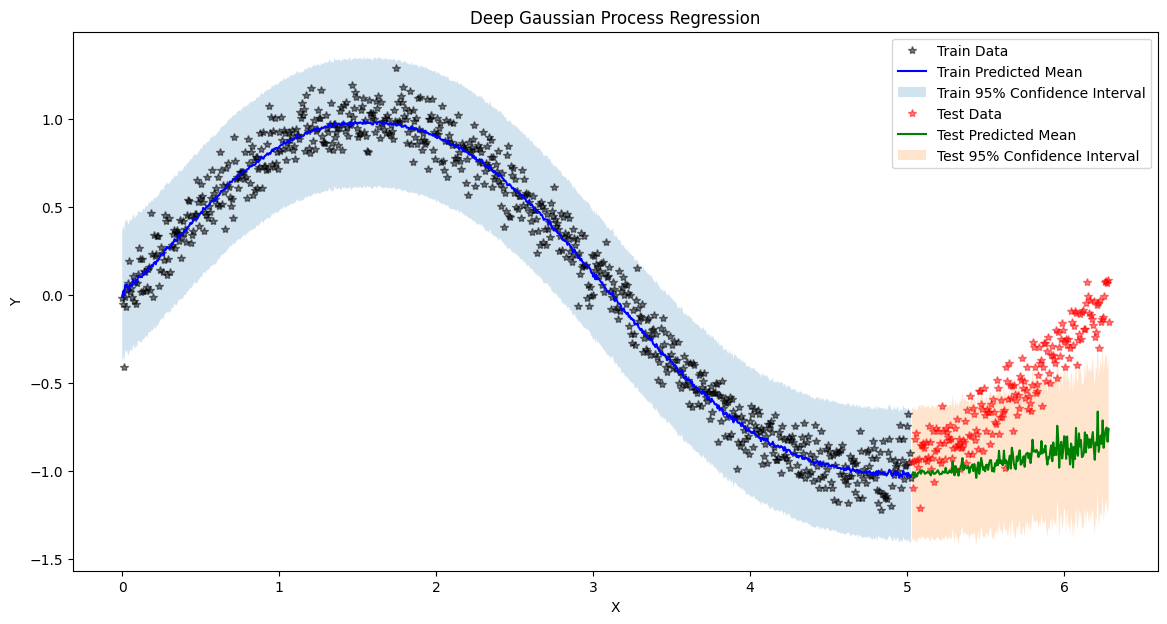

In [7]:
from matplotlib import pyplot as plt

# Convert tensors to numpy for plotting
train_predictive_means2 = train_predictive_means.mean(0).cpu().detach().numpy()
train_predictive_variances2 = train_predictive_variances.mean(0).cpu().detach().numpy()
test_predictive_means2 = test_predictive_means.mean(0).cpu().detach().numpy()
test_predictive_variances2 = test_predictive_variances.mean(0).cpu().detach().numpy()

print(train_predictive_means)

train_x_np = train_x.cpu().detach().numpy()
train_y_np = train_y.cpu().detach().numpy()
test_x_np = test_x.cpu().detach().numpy()
test_y_np = test_y.cpu().detach().numpy()

# Calculate confidence intervals for train and test sets
train_lower = train_predictive_means2 - 2 * np.sqrt(train_predictive_variances2)
train_upper = train_predictive_means2 + 2 * np.sqrt(train_predictive_variances2)
test_lower = test_predictive_means2 - 2 * np.sqrt(test_predictive_variances2)
test_upper = test_predictive_means2 + 2 * np.sqrt(test_predictive_variances2)

# Plot the results
plt.figure(figsize=(14, 7))

# Training data
plt.plot(train_x_np, train_y_np, 'k*', alpha=0.5, label='Train Data')
plt.plot(train_x_np, train_predictive_means2, 'b', label='Train Predicted Mean')
plt.fill_between(train_x_np.squeeze(), train_lower, train_upper, alpha=0.2, label='Train 95% Confidence Interval')

# Test data
plt.plot(test_x_np, test_y_np, 'r*', alpha=0.5, label='Test Data')
plt.plot(test_x_np, test_predictive_means2, 'g', label='Test Predicted Mean')
plt.fill_between(test_x_np.squeeze(), test_lower, test_upper, alpha=0.2, label='Test 95% Confidence Interval')

plt.legend()
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Deep Gaussian Process Regression')
plt.show()
